In [72]:
from PIL import Image
import os
from glob import glob
from matplotlib import pyplot as plt
import cv2
import numpy as np

## Get all of the images in the same size so they can all be processed and given the same metrics and get the same effect

In [73]:
def standardize_image(image, target_height, target_width):
    # Get current dimensions
    height, width = image.shape[:2]
    
    # Calculate scaling factors for both dimensions
    height_scale = target_height / height
    width_scale = target_width / width
    
    # Use the smaller scaling factor to maintain aspect ratio
    scale = min(height_scale, width_scale)
    
    # Calculate new dimensions
    new_height = int(height * scale)
    new_width = int(width * scale)
    
    # Resize image
    standardized = cv2.resize(image, (new_width, new_height))
    
    # Create a black canvas of target size
    final_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    # Calculate positioning to center the image
    y_offset = (target_height - new_height) // 2
    x_offset = (target_width - new_width) // 2
    
    # Place the resized image in the center of the canvas
    final_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = standardized
    
    return final_image

## Get parking lines and cars and try to isolate parking lines.
- reads image in and erodes parking lines away so you only have the cars and noise.
- dilates cars and noise so they are around biig enough to resemble the cars in the original binary image.
- xors with original binary image to try get rid of cars and noise and only be left with car lines.

In [74]:
def detect_white_lines(img):
    # Convert to HSV for better white line detection
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define range for white color to isolate it 
    lower_white = np.array([0, 0, 190])#190
    upper_white = np.array([170, 30, 255])
    # Create mask
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # Blue lines detection                                               ###Addition of blue lines detection
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([130, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(white_mask, blue_mask)
    
    kernel_clean = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))                                 ### Addition of opening
    white_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel_clean, iterations=3)

    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0][0].imshow(white_mask, cmap='gray')
    axes[0][0].set_title('Original White Mask')
    axes[0][0].axis('off')
    
    # Open the image to isolate the white blobs and remove the thin white lines
    kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (9,5))
    car_blobs = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel_car, iterations=1)
    
    axes[0][1].imshow(car_blobs, cmap='gray')
    axes[0][1].set_title('Dilated Blobs')
    axes[0][1].axis('off')
    
    
    #Dilate Blobs to get them the same size as before we opened tehm above for the xor operation
    kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    car_blobs = cv2.morphologyEx(car_blobs, cv2.MORPH_DILATE, kernel_car, iterations=2)
    
    axes[0][2].imshow(car_blobs, cmap='gray')
    axes[0][2].set_title('Eroded Blobs')
    axes[0][2].axis('off')
    
    # AND between original and inverted car blobs to keep only lines and get rid of car blobs
    car_mask = cv2.bitwise_not(car_blobs)
    just_lines = cv2.bitwise_and(white_mask, car_mask)
    
    axes[1][0].imshow(car_mask, cmap='gray')
    axes[1][0].set_title('Car Mask (Inverted)')
    axes[1][0].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return just_lines

## Once we have parking lines isolated try to improve their visibility so cropping can take place. 
- Firstly blur the image to try minimise nosie.
- Carry out edge detection to impose teh parking lines and get rid of nosie that isn't a majopor edge. 
- Carry out hough transform to try and build lines and join themm together 
- Do dilation and erosion to make the lines stand out a little more before cropping. 

In [75]:
def detect_parking_lines(img):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    #Apply edge detection to the system to detect lines can create a little bit of noise but makes lines more visible before Hough transform   
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 100)
    
    axes[0][0].imshow(edges, cmap='gray')
    axes[0][0].set_title('Edge Detection')
    axes[0][0].axis('off')
    
    #Use Hough transform to connect the lines that have now been detected and connect some of the gaps between the lines
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=40,#40 #20 medium
        minLineLength=50,  # Minimum length of line
        maxLineGap=20 #50      # Maximum gap between line segments
    )
    
    #Group horizontal and vertical lines together  
    horizontal_lines = np.zeros_like(gray)
    vertical_lines = np.zeros_like(gray)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # Calculate line angle
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi)
            
            # Calculate line length
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            # Classify lines based on angle
            if (angle < 15) or (angle > 165):  #Horizontal lines
                if length > 100:  #Filter by minimum length
                    cv2.line(horizontal_lines, (x1, y1), (x2, y2), 255, 2)
            elif (75 < angle < 105):  #Vertical lines
                if length > 50:  #Filter by minimum length
                    cv2.line(vertical_lines, (x1, y1), (x2, y2), 255, 2)
    
    axes[0][1].imshow(horizontal_lines, cmap='gray')
    axes[0][1].set_title('Horizontal Lines')
    axes[0][1].axis('off')
    
    axes[0][2].imshow(vertical_lines, cmap='gray')
    axes[0][2].set_title('Vertical Lines')
    axes[0][2].axis('off')
    
    # Combine horizontal and vertical lines
    combined_lines = cv2.bitwise_or(horizontal_lines, vertical_lines)
    
    # Clean up the lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    cleaned_lines = cv2.morphologyEx(combined_lines, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    axes[1][0].imshow(cleaned_lines, cmap='gray')
    axes[1][0].set_title('Combined Lines')
    axes[1][0].axis('off')
    
    # Hide unused subplot
    axes[1][1].axis('off')  ##Two axises were used for operations but operations didn't have positive impact on the image
    axes[1][2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return cleaned_lines

The two methods above perform reasoably well however noise removal can definitely be improved for the implementation with noise being carried down throught he pipeline and leading to poor performance at times. 
An iteractive approach to removing the blobs would lead to more nosie being removed like doing the blob detection in a for loop and slowly removing smaller and smaller blobs until you get down to around the same size as the parking lines. 
These two methods are the key to making sure the rest of the pipeline performs well. 
Obvously kernels need to be adjusted and thresholds need to be adjusted for iamge 2. 

In [76]:
#Method used to rotate the image to make it horizontal allowing for better line detection
def rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width/2, height/2)
    
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (width, height))
    
    return rotated

Rotation method works well but would be better if the rotation was automatically applied and also more rigourous testing required to amke sure you don't rotate the image out of bounds and end up with a black edge in your cropping as this heavily effects occupancy detection.

## Crop image to only detect parking spaces
Try crop the parking regions out based on the vertiical and horizontal lines that have been created in the previous method so we are only left with parking spaces and cars it should be alot easier to then see the occupancy of parkking spaces. 

In [77]:
def crop_parking_regions(parking_area, original_img):
    height, width = parking_area.shape[:2]
    padding_y = -10
    padding_x = 20
    
    # Get projections
    horizontal_projections = np.sum(parking_area, axis=1) #Basically add up all the rows and columns and see how many white pixels is in them
    vertical_projections = np.sum(parking_area, axis=0)
    
    #Normalize projections
    horizontal_projections = horizontal_projections / width #Need to normalise these values in order to be able threshold them 
    vertical_projections = vertical_projections / height
    
    #Find significant horizontal lines
    horizontal_lines = np.where(horizontal_projections > 0.15)[0] ##Anywhere where the projection is greater than 0.15 we will consider it a line in vertical or horizontal direction
    vertical_lines = np.where(vertical_projections > 0.15)[0]
    
    # Group horizontal lines by proximity
    grouped_lines = []
    current_group = [horizontal_lines[0]]
    
    for i in range(1, len(horizontal_lines)):
        if horizontal_lines[i] - horizontal_lines[i-1] < 20: #If the distance between one line and another is under 20 see it as the same parking area
            current_group.append(horizontal_lines[i])
        else:
            grouped_lines.append(current_group)  #If the distance is greater than 20 then it is a new parking area
            current_group = [horizontal_lines[i]]
    grouped_lines.append(current_group)
    
    crop_coordinates = []  # Store the coordinates for cropping
    min_region_height = height * 0.15
    
    # Find x boundaries using vertical lines - do this once for all crops
    x_start = max(0, vertical_lines[0] - padding_x)  ##making sure start and end is within the image bounds 
    x_end = min(width, vertical_lines[-1] + padding_x)
    
    for i, group in enumerate(grouped_lines):
        if i == 0 or i == len(grouped_lines) - 1:  # more leniant for top or bottom as there might be partial spaces
            start = max(0, min(group) - padding_y)   ##making sure the crop doesn't go off image
            end = min(height, max(group) + padding_y)
            if end - start > min_region_height: # Only consider regions with a minimum height
                crop_coordinates.append((start, end, x_start, x_end))
        else:  # Middle groups need to be more strict
            start = max(0, min(group) - padding_y)
            end = min(height, max(group) + padding_y)
            if end - start > height * 0.2:
                crop_coordinates.append((start, end, x_start, x_end))
    
    num_regions = len(crop_coordinates)
    fig = plt.figure(figsize=(15, 5 * num_regions))
    
    binary_crops = []
    original_crops = []
    
    for i, (y_start, y_end, x_start, x_end) in enumerate(crop_coordinates):
        #Plot each crop depending how many there is 
        binary_crop = parking_area[y_start:y_end, x_start:x_end]
        original_crop = original_img[y_start:y_end, x_start:x_end].copy()  # Make a copy to avoid reference issues
        
        binary_crops.append(binary_crop)
        original_crops.append(original_crop)
        
        ax1 = fig.add_subplot(num_regions, 2, 2*i + 1)
        ax1.imshow(binary_crop, cmap='gray')
        ax1.set_title(f'Region {i+1} - Binary\nSize: {binary_crop.shape}')
        ax1.axis('off')
        
        ax2 = fig.add_subplot(num_regions, 2, 2*i + 2)
        ax2.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'Region {i+1} - Original\nSize: {original_crop.shape}')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
        
    return binary_crops, original_crops, crop_coordinates

The cropping of the parking regions performs well except for the third image where the roadway isn't croppped out of the image this causes a false parking space detection. 
Also image 3s performance is very poor aswell but wasn't able to finsih it due to time management probelms.

## Use line transitions to detect vertical and horizontal peaks using thresjolding these peaks will describe the parking lines if perfromed correctly. Parking spots aren't detected in this method but the v_peask and h_peask are used for parking spot detection in the next method

In [78]:
def detect_parking_spaces(binary_crop, original_crop):
    height, width = binary_crop.shape[:2]
    
    # Calculate projections and normalize
    vertical_proj = np.sum(binary_crop, axis=0)
    horizontal_proj = np.sum(binary_crop, axis=1)
    vertical_proj = vertical_proj / np.max(vertical_proj)
    
    # Find peaks for vertical lines
    window_size = 3
    v_peaks = []
    for i in range(window_size, len(vertical_proj) - window_size):
        window = vertical_proj[i-window_size:i+window_size]
        if (vertical_proj[i] >= max(window) and 
            vertical_proj[i] > 0.35 and
            (not v_peaks or i - v_peaks[-1] >= 50)):
            v_peaks.append(i)
    
    # Add edge peaks if they're close to expected spacing
    if len(v_peaks) > 1:
        avg_spacing = np.mean([v_peaks[i+1] - v_peaks[i] for i in range(len(v_peaks)-1)]) ##average spacing and compare this to edge cases to see if they should be included
        
        # Check left edge
        if v_peaks[0] > avg_spacing * 0.5:  ##if they are withing 50% of the average spacing they are included
            v_peaks.insert(0, 0)
            
        # Check right edge
        if (width - v_peaks[-1]) > avg_spacing * 0.7:  ##if they are withing 70% of the average spacing they are included
            v_peaks.append(width)
    
    
    h_threshold = 100000
    h_peaks = []
    
    for i in range(len(horizontal_proj)):
        if (horizontal_proj[i] > h_threshold and
            (not h_peaks or i - h_peaks[-1] >= 20)):
            h_peaks.append(i)

    # Draw visualization
    result = original_crop.copy()
    
    # Draw vertical and horizontal lines
    for x in v_peaks:
        cv2.line(result, (x, 0), (x, height), (0, 0, 255), 2)
    
    for y in h_peaks:
        cv2.line(result, (0, y), (width, y), (0, 0, 255), 2)
        
    spot_number = 1
    min_spot_width = 20  # Minimum width 
    
    if len(h_peaks) > 0:  # If we have horizontal divisions
        for i in range(len(v_peaks)-1):
            x1, x2 = v_peaks[i], v_peaks[i+1]
            spot_width = x2 - x1
            
            if spot_width < min_spot_width:
                continue
                
            # Upper spot
            y1, y2 = 0, h_peaks[0]
            spot_height = y2 - y1
            aspect_ratio = spot_width / spot_height if spot_height > 0 else 0
            
            if 0.2 <= aspect_ratio <= 3.0 and spot_width >= min_spot_width:
                cv2.rectangle(result, (x1, y1), (x2, y2), (255, 165, 0), 2)
                cv2.putText(result, str(spot_number), 
                           ((x1 + x2)//2, (y1 + y2)//2),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 165, 0), 2)
                spot_number += 1
            
            # Lower spot
            y1, y2 = h_peaks[0], height
            spot_height = y2 - y1
            aspect_ratio = spot_width / spot_height if spot_height > 0 else 0
            
            if 0.2 <= aspect_ratio <= 3.0 and spot_width >= min_spot_width:
                cv2.rectangle(result, (x1, y1), (x2, y2), (255, 165, 0), 2)
                cv2.putText(result, str(spot_number), 
                           ((x1 + x2)//2, (y1 + y2)//2),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 165, 0), 2)
                spot_number += 1
    
    # Visualization
    fig, axes = plt.subplots(4, 1, figsize=(15, 16))
    
    axes[0].imshow(binary_crop, cmap='gray')
    axes[0].set_title('Binary Image')
    axes[0].axis('off')
    
    axes[1].plot(vertical_proj)
    axes[1].axhline(y=0.3, color='r', linestyle='--', label='Peak Threshold')
    axes[1].set_title('Vertical Projection')
    axes[1].legend()
    
    axes[2].plot(horizontal_proj)
    axes[2].axhline(y=h_threshold, color='r', linestyle='--', label='Threshold')
    axes[2].set_title('Horizontal Projection')
    axes[2].legend()
    
    axes[3].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axes[3].set_title('Detected Parking Spaces')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return v_peaks, h_peaks, result

## This method takes in the peaks and sees if they reaching the sizing requirements to be considered as a parking spot if they do they are carried down further to the occupancy detection

In [79]:
def extract_parking_spots(original_img, v_peaks, h_peaks):
    height, width = original_img.shape[:2]
    parking_spots = []
    
    # Define vertical sections between consecutive v_peaks
    for i in range(len(v_peaks)-1):
        x1 = v_peaks[i]
        x2 = v_peaks[i+1]
        
        if len(h_peaks) == 0:
            #If no horizontal peaks, treat as one section
            spot = {
                'coords': (x1, 0, x2, height),
                'roi': original_img[0:height, x1:x2]
            }
            parking_spots.append(spot)
        else:
            # Create sections between horizontal lines
            y_sections = [0] + h_peaks + [height]
            for j in range(len(y_sections)-1):
                y1 = y_sections[j]
                y2 = y_sections[j+1]
                
                if 100 > (x2 - x1) > 20 and (y2 - y1) > 20: #included if it in withiin  the required dimensions
                    spot = {
                        'coords': (x1, y1, x2, y2),
                        'roi': original_img[y1:y2, x1:x2]
                    }
                    parking_spots.append(spot)
    
    return parking_spots

Parking spot detection works well for the first and third image with the only problem being the y roadway  being detected in image three and in also the footpath being detected that image aswell. This parking spot detection would be improved with better perfroming areas earlier in the pipeline for example the cropping region being able to crop the two parking lots without the inclusion of the roadway in the middle and then this method would succesfully be able to detect all of the parking spaces succesfully

In [80]:
def analyze_parking_spot_occupancy(original_crop, spots):
    
    results = []
    vis_img = original_crop.copy()
    
    for i, spot in enumerate(spots, 1):
        x1, y1, x2, y2 = spot['coords']
        spot_roi = spot['roi']
        
        # Convert spot to grayscale for analysis
        gray = cv2.cvtColor(spot_roi, cv2.COLOR_BGR2GRAY)
        
        # Calculate key metrics for occupancy detection
        variance = np.var(gray)
        mean_intensity = np.mean(gray)
        
        # Edge detection to identify potential vehicle edges
        edges = cv2.Canny(gray, 50, 150)
        edge_density = np.sum(edges > 0) / (edges.size)
        
        # Print diagnostic information for creating thresholds etc
        print(f"\nAnalyzing Space {i}:")
        print(f"Variance: {variance:.2f}")
        print(f"Mean Intensity: {mean_intensity:.2f}")
        print(f"Edge density: {edge_density:.3f}")
        
        # Occupancy criteria 
        # You might need to tune these thresholds based on your specific parking lot
        is_occupied = variance > 1200 and edge_density > 0.10  ##Uses edge density and variance to determine if the spot is occupied
        
        color = (0, 0, 255) if is_occupied else (0, 255, 0)
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
        label = f"{i}: {'Occ' if is_occupied else 'Vac'}"
        cv2.putText(vis_img, label, (x1+5, y1+20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # Store results
        results.append({
            'coords': (x1, y1, x2, y2),
            'occupied': is_occupied,
            'metrics': {
                'variance': variance,
                'mean_intensity': mean_intensity,
                'edge_density': edge_density
            }
        })
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
    plt.title('Original Crop')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title('Occupancy Analysis')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results, vis_img

Occuapnacy detection could be improved with better testing with the majority of parking spots performing well however edge cases need work and in this case image 3s occupancy detection needs better testing. 
For more obvious images like image 1 the performance is alot better.

## Discussion and Crituque
The main improvement to be made in this image set is the second image. 
The first images performance works very well although it would be better if the rotation was automatically applied rather then the manual input that is used however the implementation works well for this application
The third image performs well but improvements could be made for the rotation method to make sure that the rotation doesn't put the image straight off the page. Also improvemts to the occupancy detection would improve the perofrmance of this image as the parking spaces are actually detected well except for the roadway being incorrectly detected however the occupancy detection is not good for this image. 

# MAIN PROCESSING  LOOP

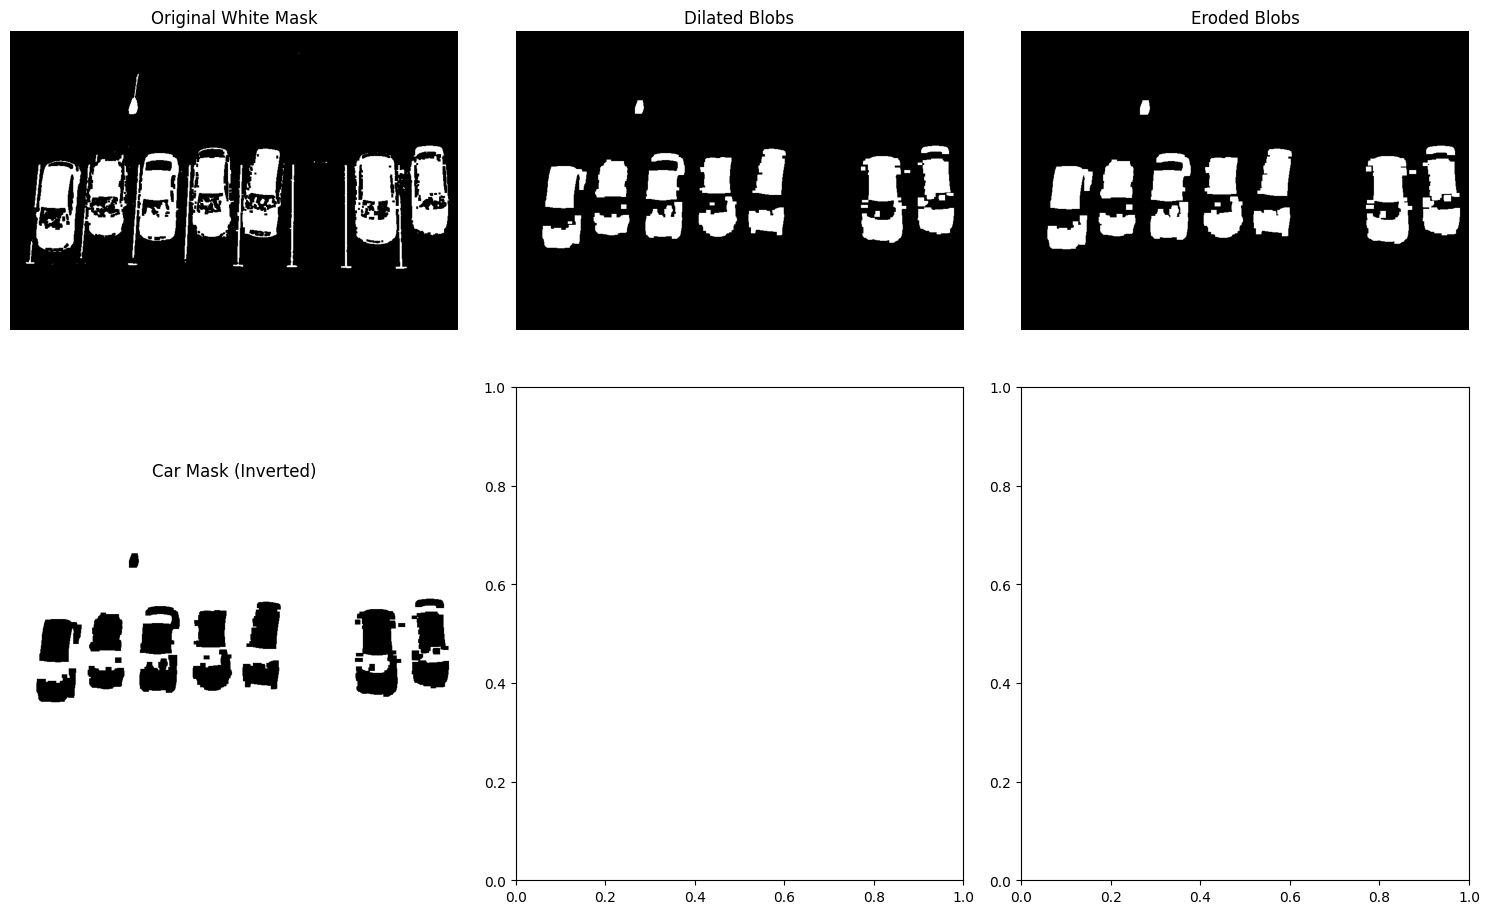

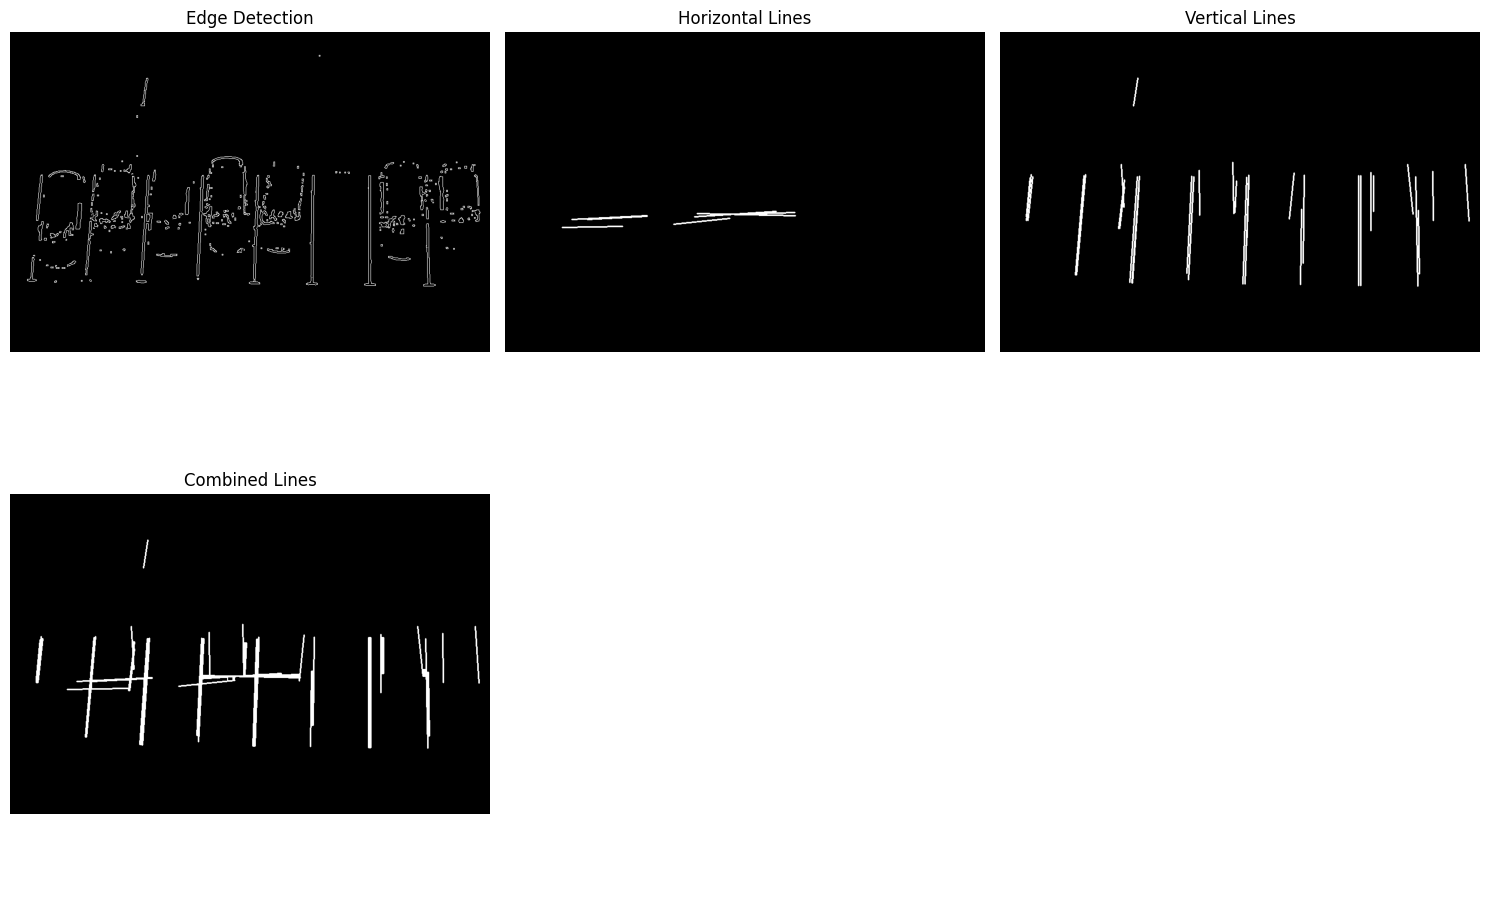

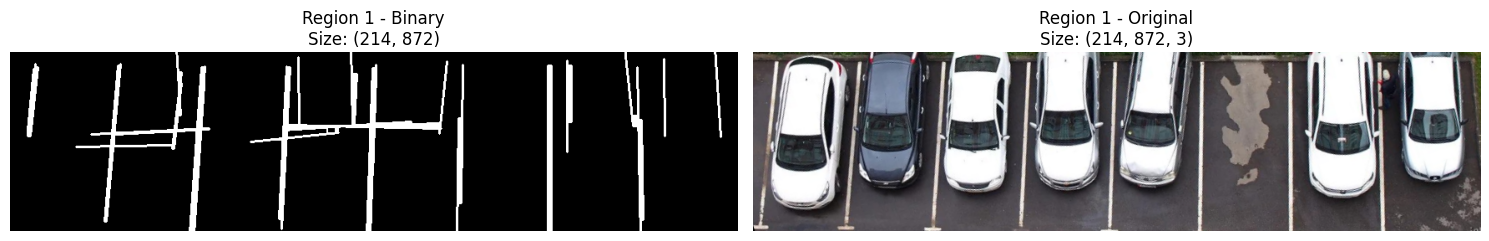

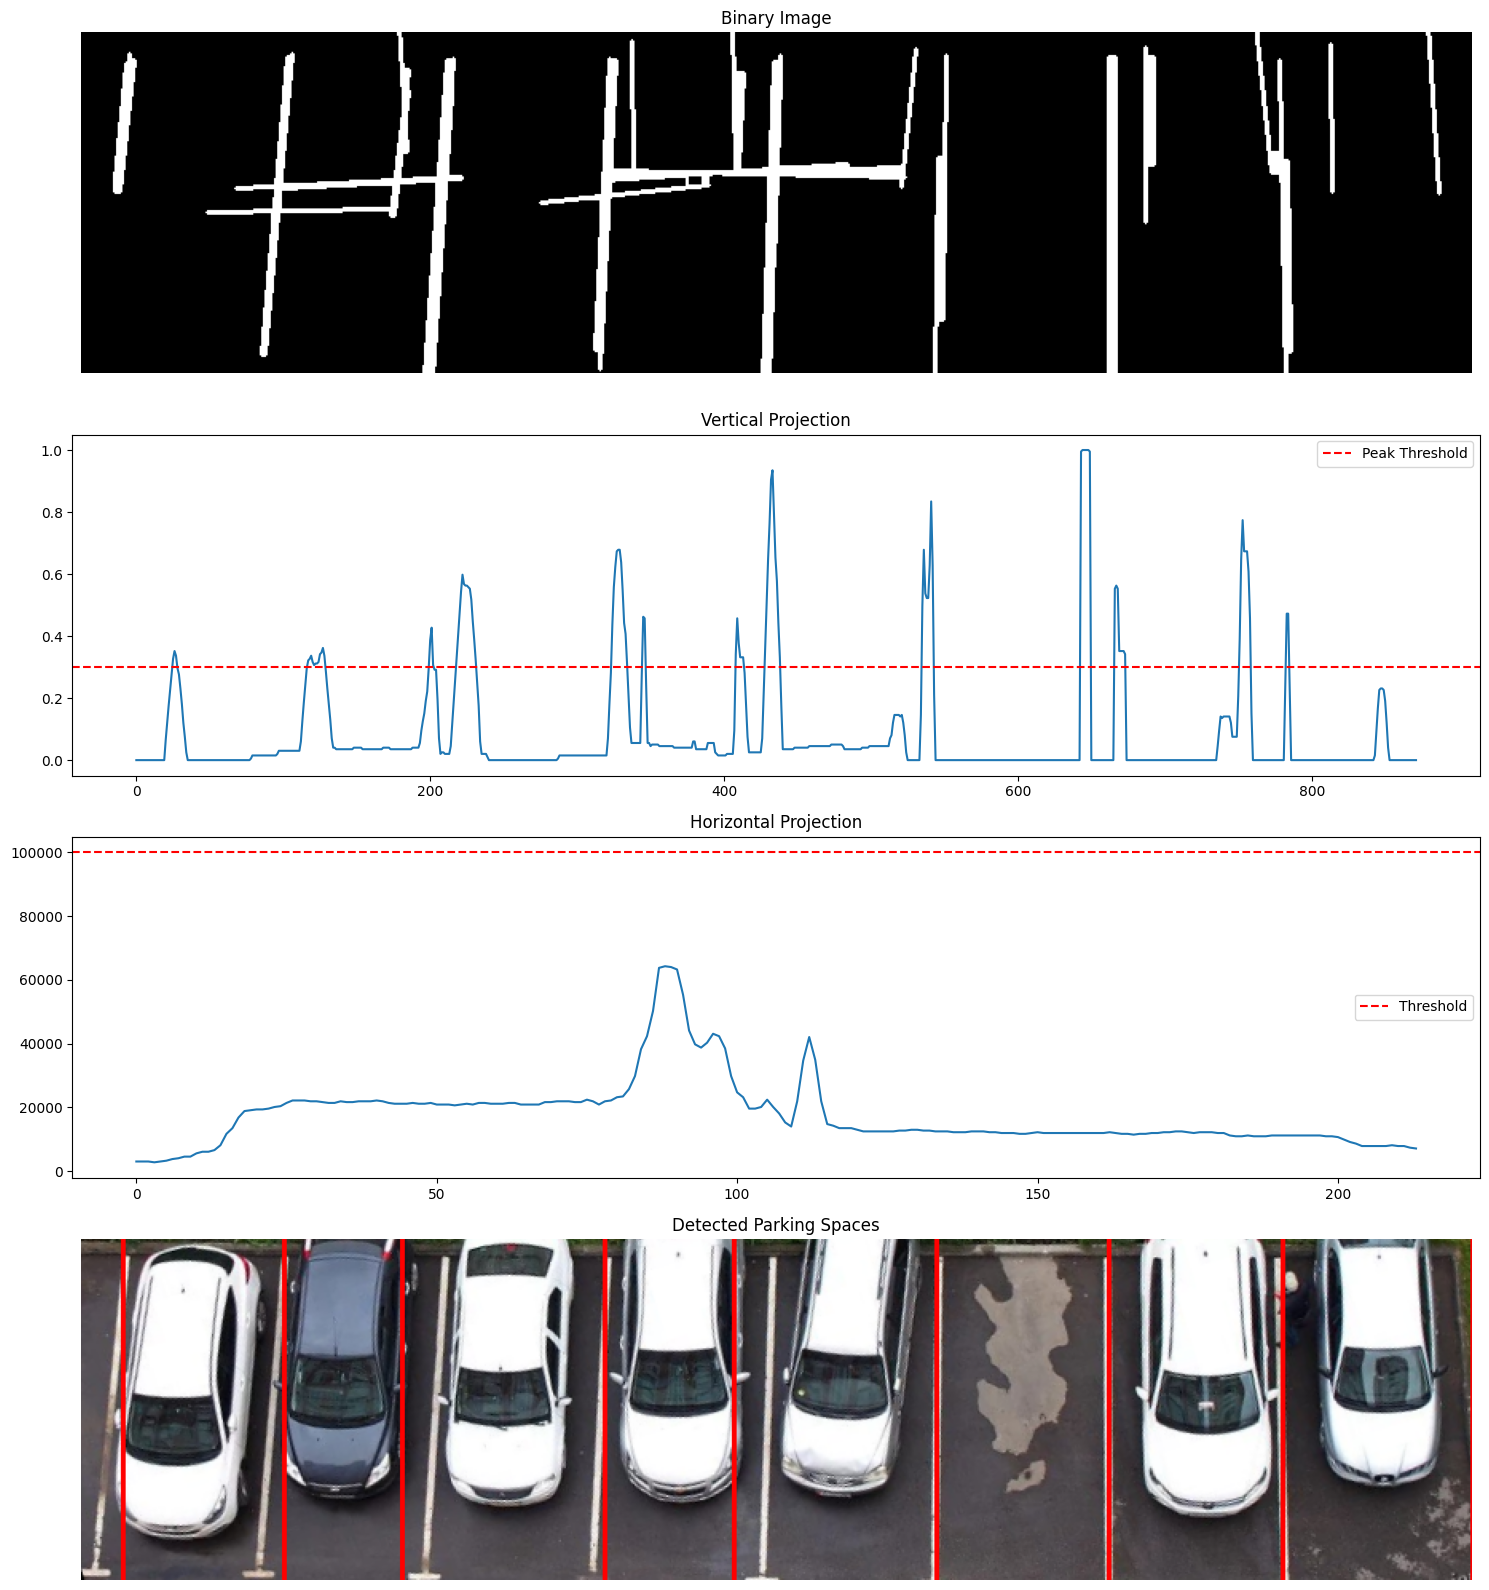


Analyzing Space 1:
Variance: 8350.67
Mean Intensity: 138.59
Edge density: 0.137

Analyzing Space 2:
Variance: 1770.97
Mean Intensity: 82.80
Edge density: 0.122

Analyzing Space 3:
Variance: 7222.94
Mean Intensity: 123.01
Edge density: 0.103

Analyzing Space 4:
Variance: 7840.81
Mean Intensity: 137.56
Edge density: 0.119

Analyzing Space 5:
Variance: 5964.38
Mean Intensity: 115.54
Edge density: 0.119

Analyzing Space 6:
Variance: 1682.92
Mean Intensity: 95.31
Edge density: 0.057

Analyzing Space 7:
Variance: 8244.68
Mean Intensity: 141.88
Edge density: 0.106

Analyzing Space 8:
Variance: 6665.91
Mean Intensity: 108.31
Edge density: 0.122


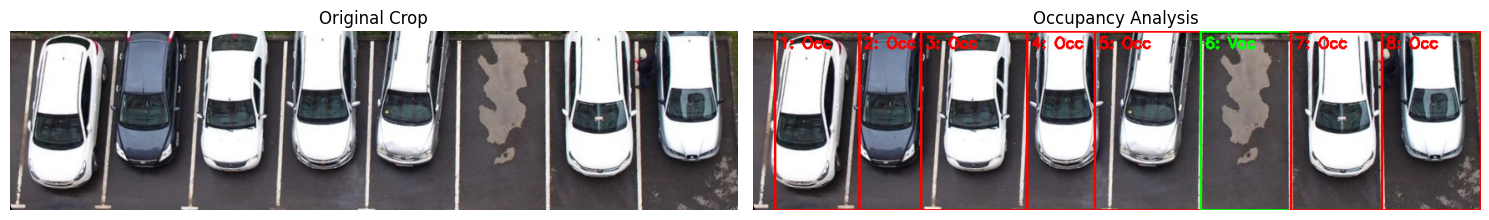

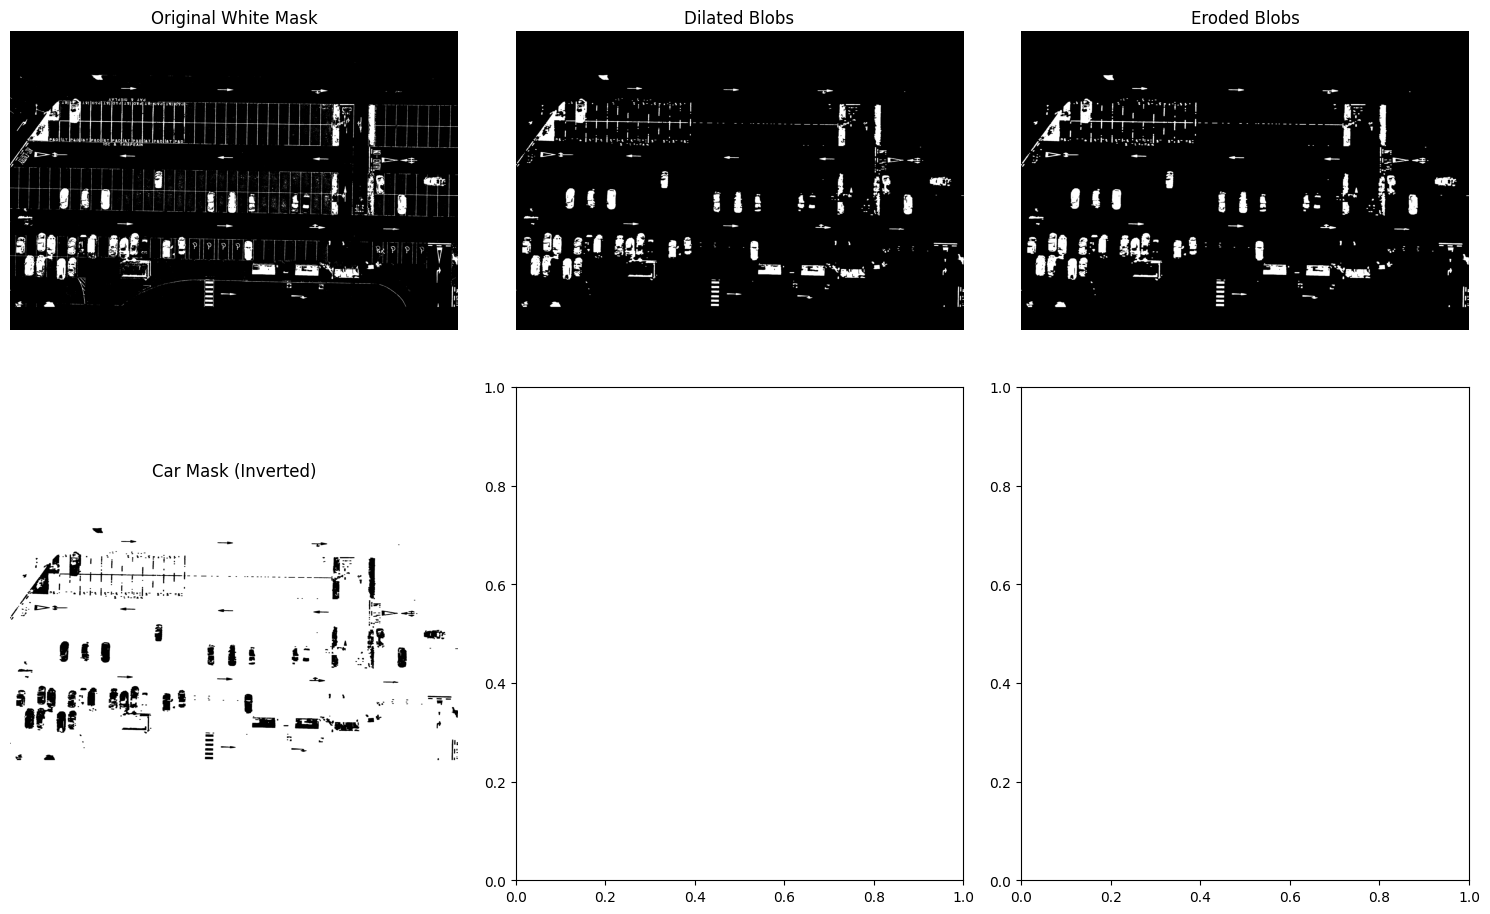

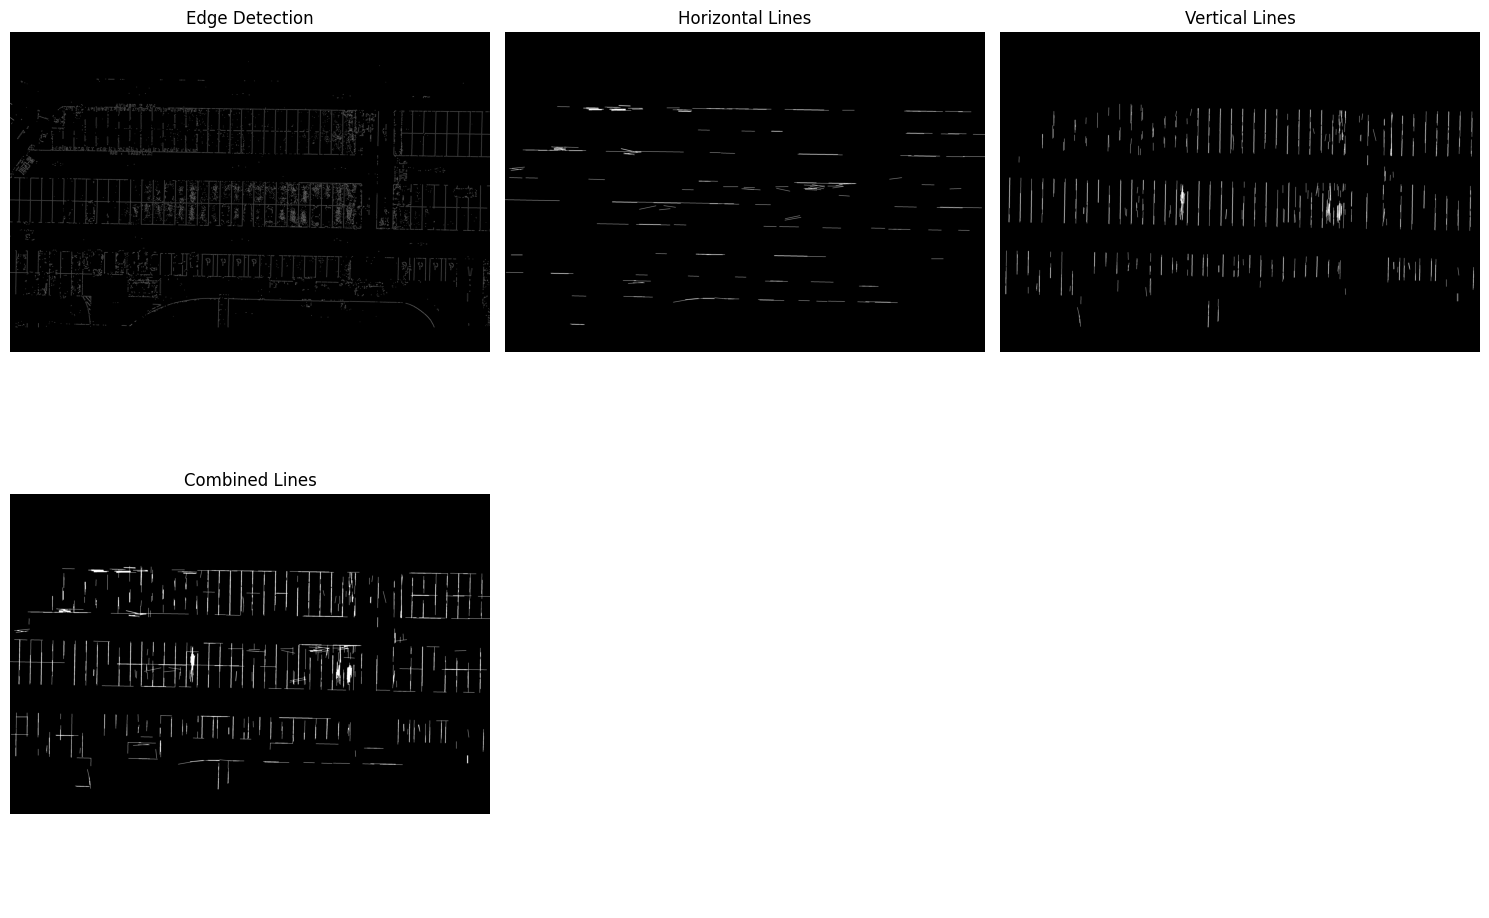

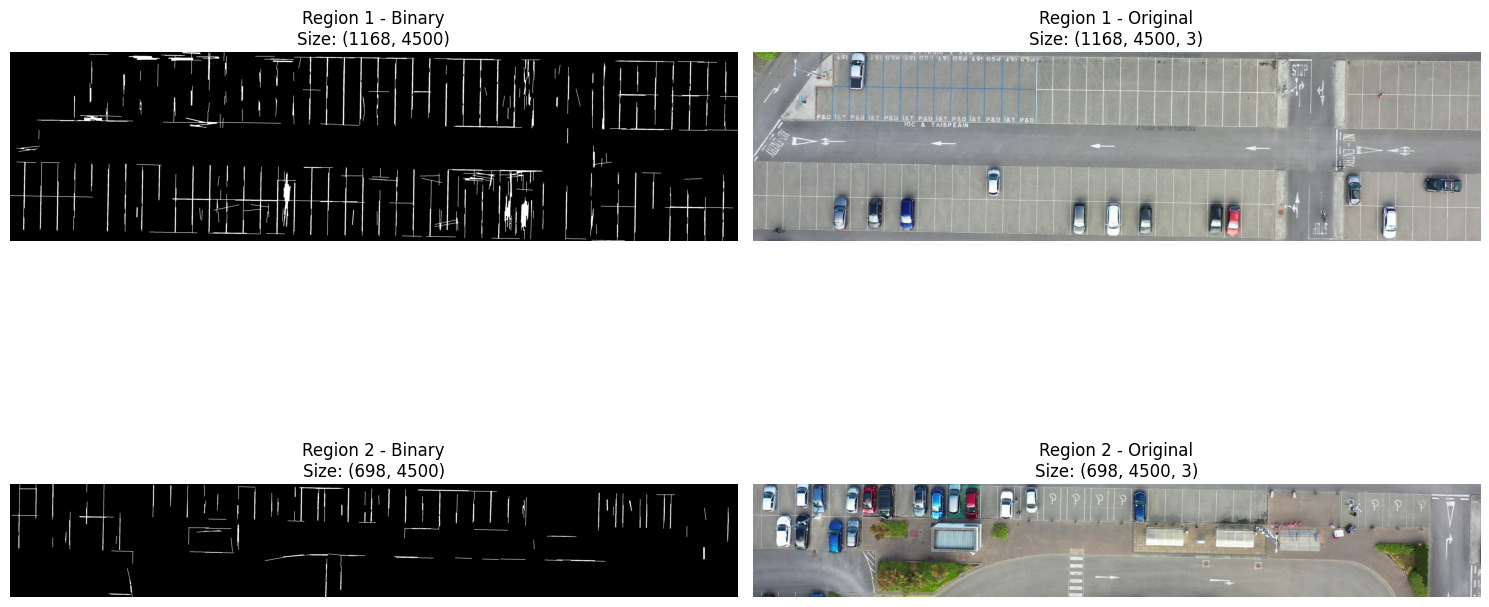

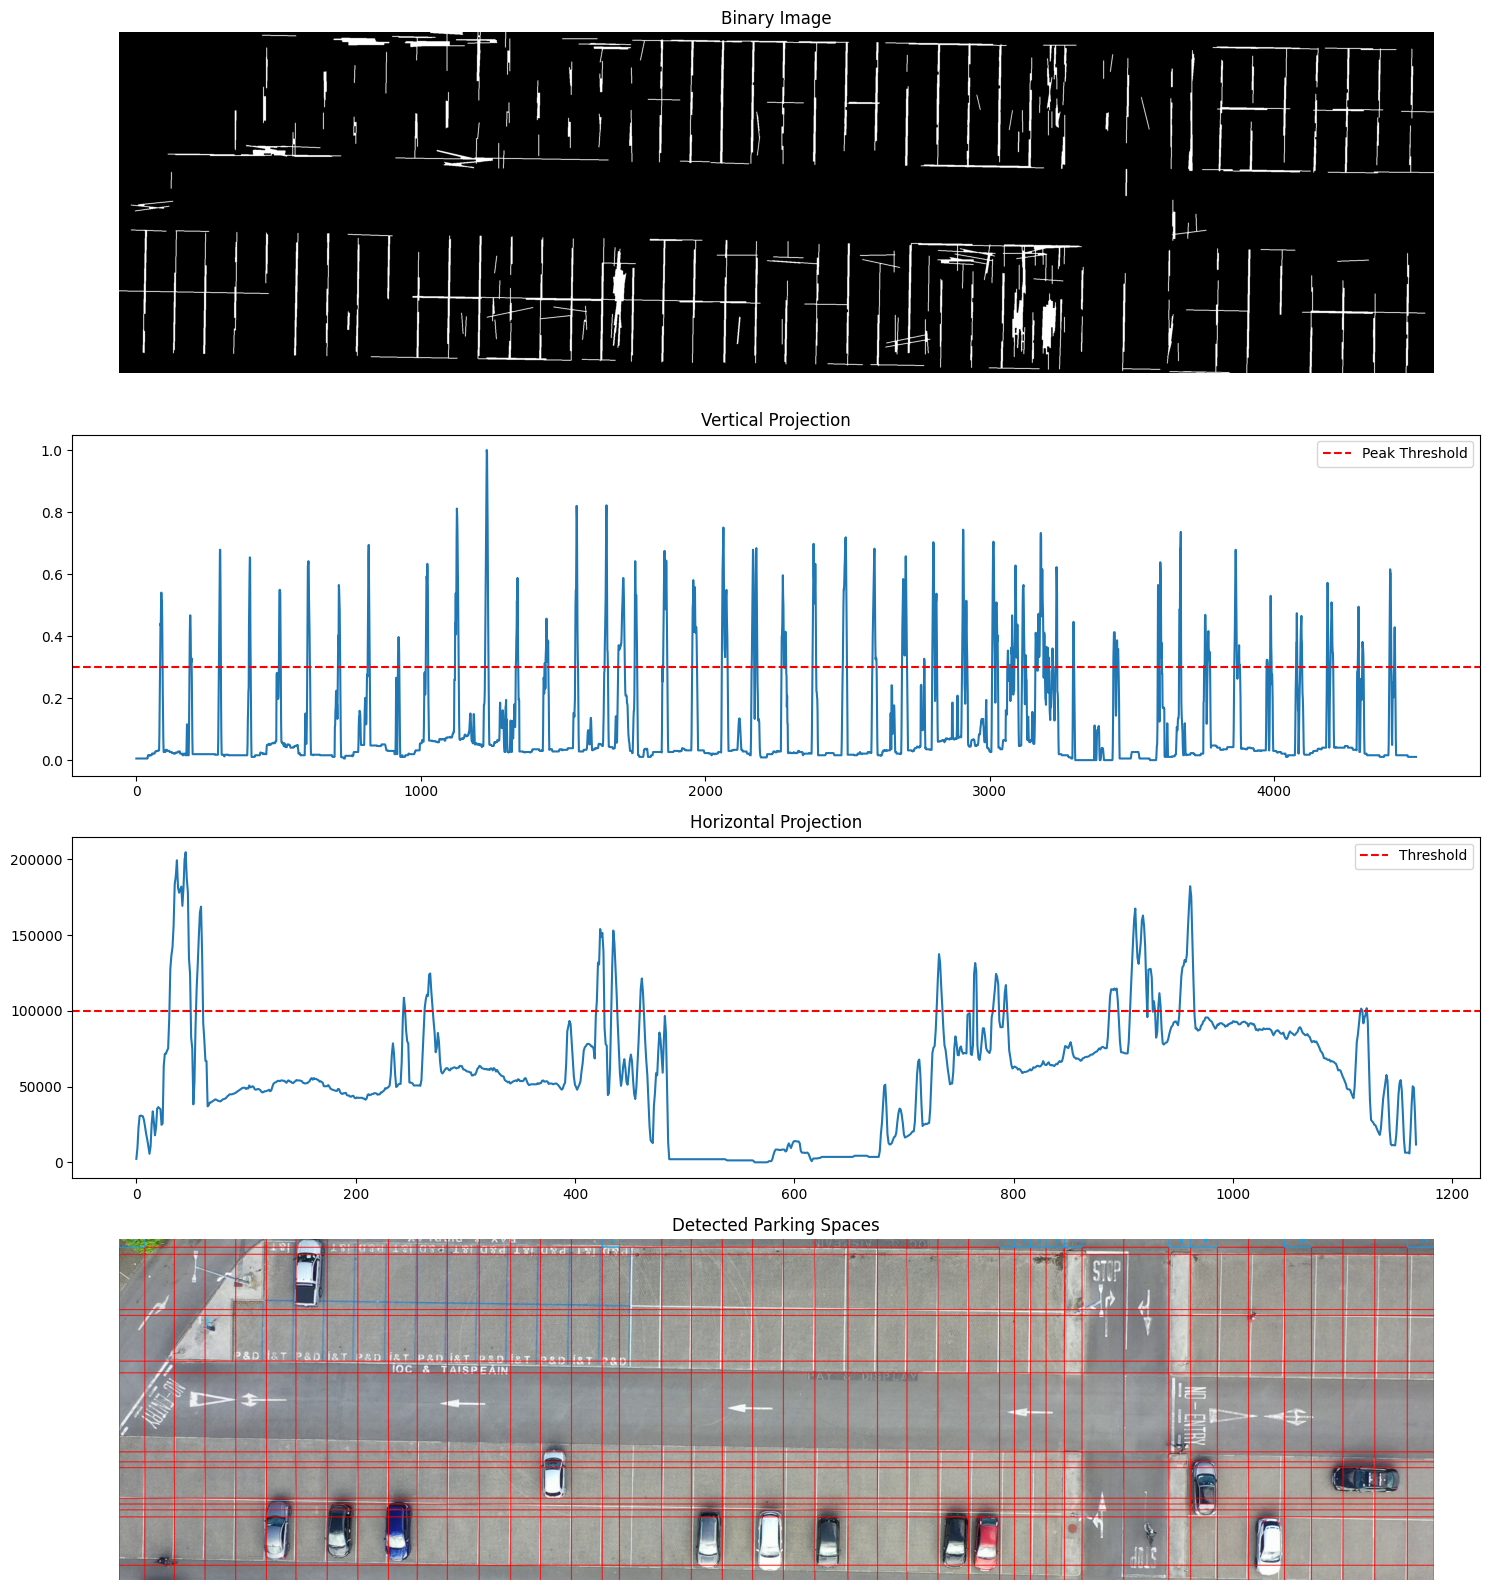


Analyzing Space 1:
Variance: 514.34
Mean Intensity: 122.10
Edge density: 0.262

Analyzing Space 2:
Variance: 270.01
Mean Intensity: 122.87
Edge density: 0.217

Analyzing Space 3:
Variance: 185.44
Mean Intensity: 134.63
Edge density: 0.134

Analyzing Space 4:
Variance: 118.17
Mean Intensity: 145.40
Edge density: 0.008

Analyzing Space 5:
Variance: 19.62
Mean Intensity: 148.02
Edge density: 0.000

Analyzing Space 6:
Variance: 611.05
Mean Intensity: 150.72
Edge density: 0.070

Analyzing Space 7:
Variance: 170.46
Mean Intensity: 148.29
Edge density: 0.109

Analyzing Space 8:
Variance: 360.94
Mean Intensity: 149.48
Edge density: 0.032

Analyzing Space 9:
Variance: 193.65
Mean Intensity: 154.43
Edge density: 0.062

Analyzing Space 10:
Variance: 318.73
Mean Intensity: 147.75
Edge density: 0.037

Analyzing Space 11:
Variance: 52.07
Mean Intensity: 122.71
Edge density: 0.000

Analyzing Space 12:
Variance: 645.57
Mean Intensity: 161.44
Edge density: 0.135

Analyzing Space 13:
Variance: 589.05
M

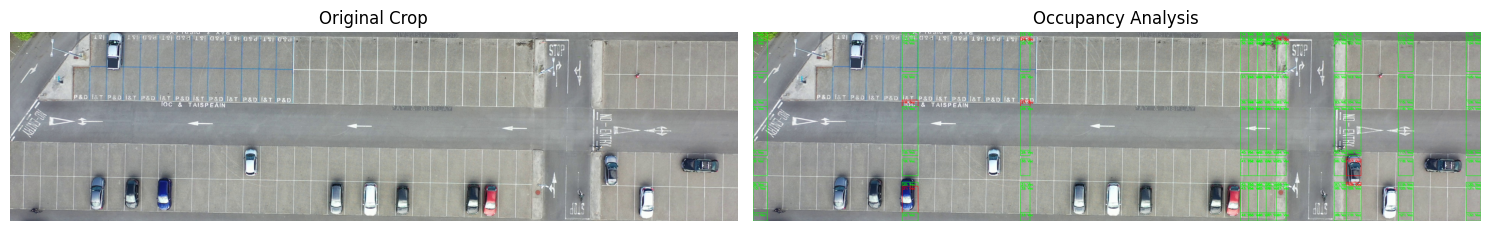

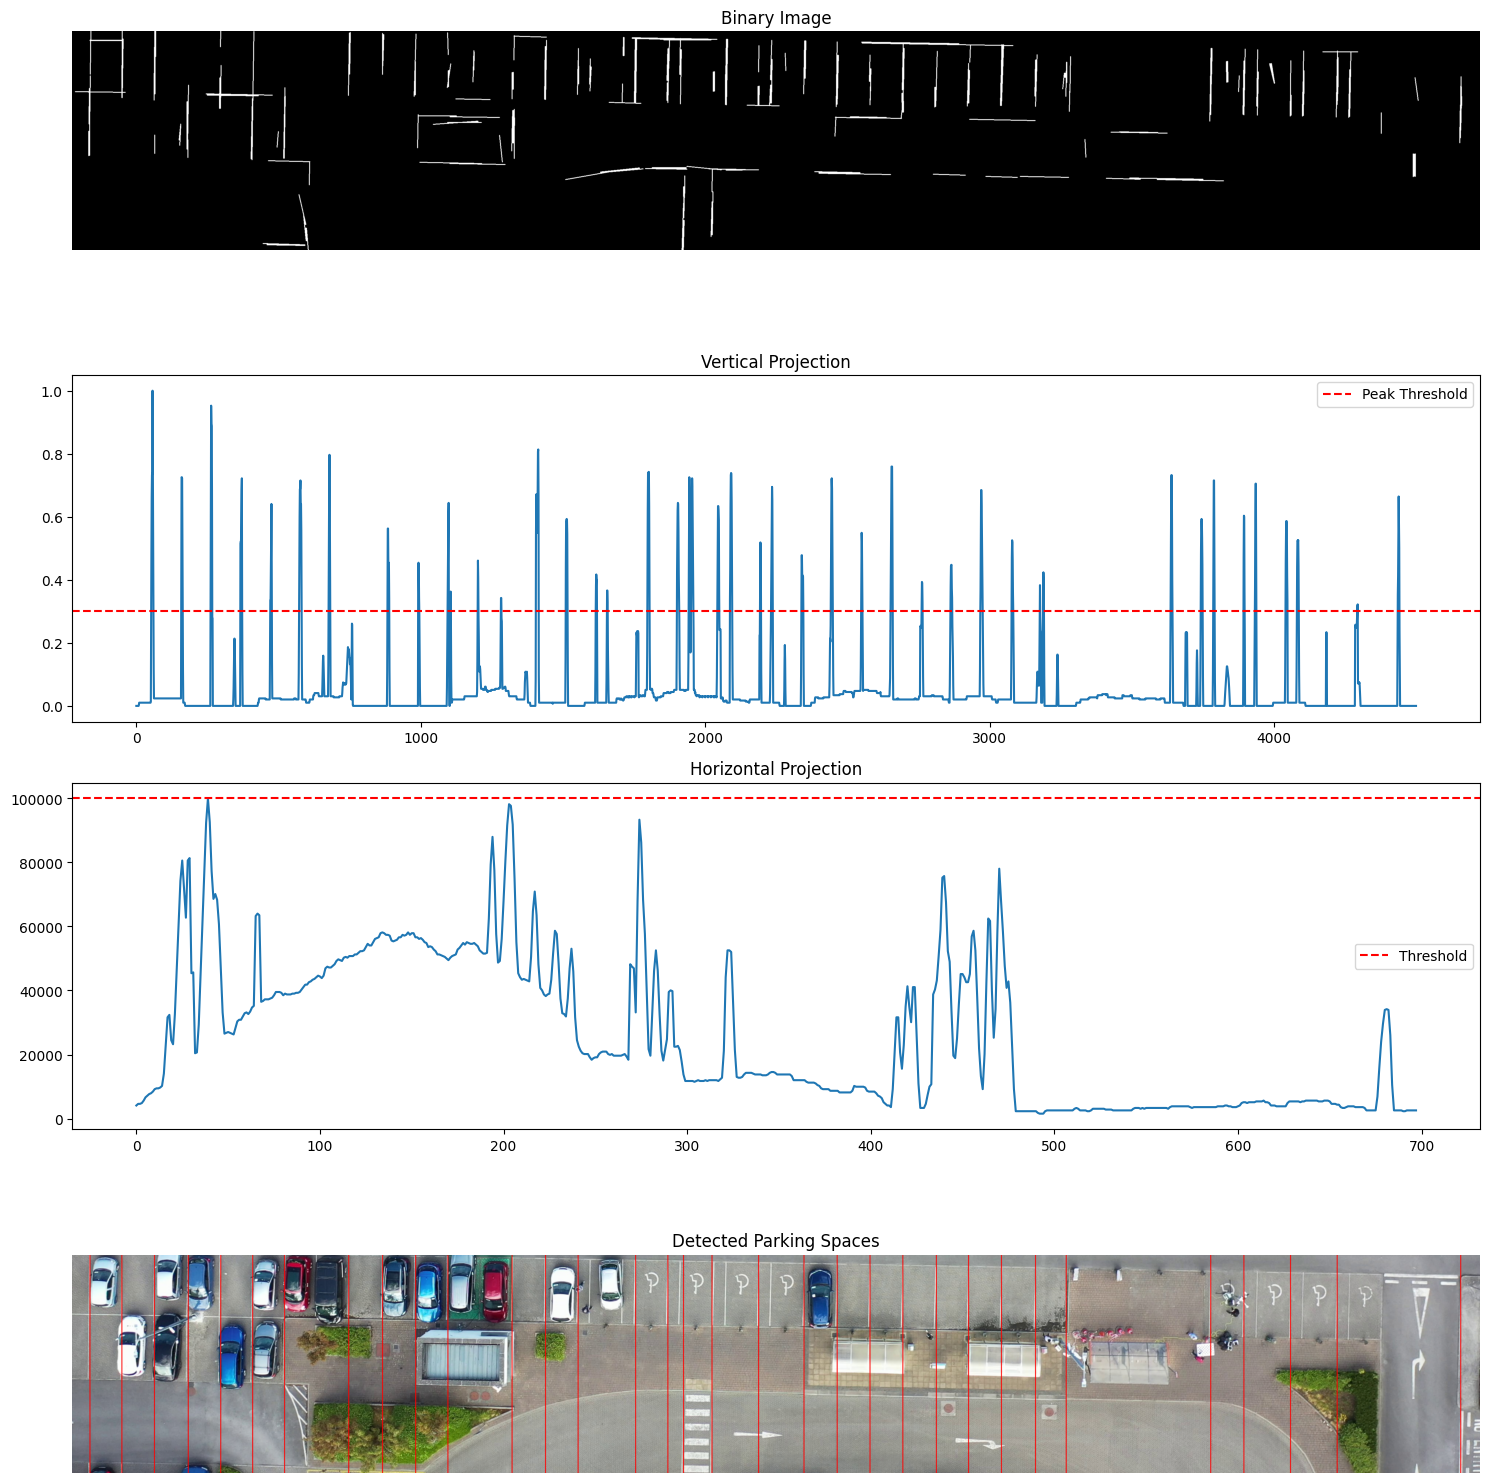


Analyzing Space 1:
Variance: 1961.13
Mean Intensity: 136.41
Edge density: 0.046

Analyzing Space 2:
Variance: 2174.07
Mean Intensity: 143.26
Edge density: 0.042

Analyzing Space 3:
Variance: 2859.51
Mean Intensity: 119.26
Edge density: 0.077

Analyzing Space 4:
Variance: 1537.47
Mean Intensity: 134.91
Edge density: 0.074

Analyzing Space 5:
Variance: 1669.96
Mean Intensity: 128.21
Edge density: 0.052

Analyzing Space 6:
Variance: 2423.57
Mean Intensity: 137.87
Edge density: 0.091

Analyzing Space 7:
Variance: 1879.25
Mean Intensity: 105.10
Edge density: 0.150

Analyzing Space 8:
Variance: 1106.73
Mean Intensity: 110.60
Edge density: 0.181

Analyzing Space 9:
Variance: 1751.09
Mean Intensity: 103.68
Edge density: 0.163

Analyzing Space 10:
Variance: 2530.44
Mean Intensity: 113.57
Edge density: 0.170

Analyzing Space 11:
Variance: 2708.70
Mean Intensity: 127.38
Edge density: 0.126

Analyzing Space 12:
Variance: 485.23
Mean Intensity: 147.70
Edge density: 0.055

Analyzing Space 13:
Varia

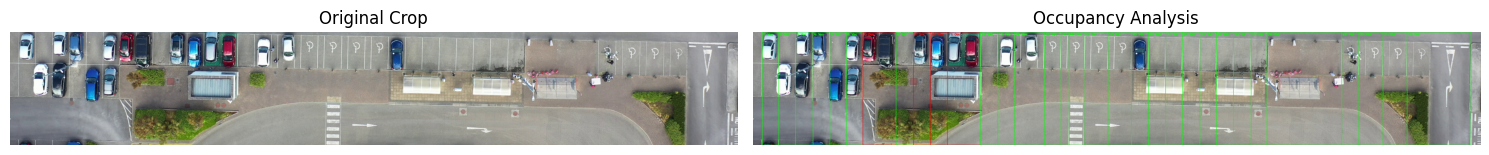

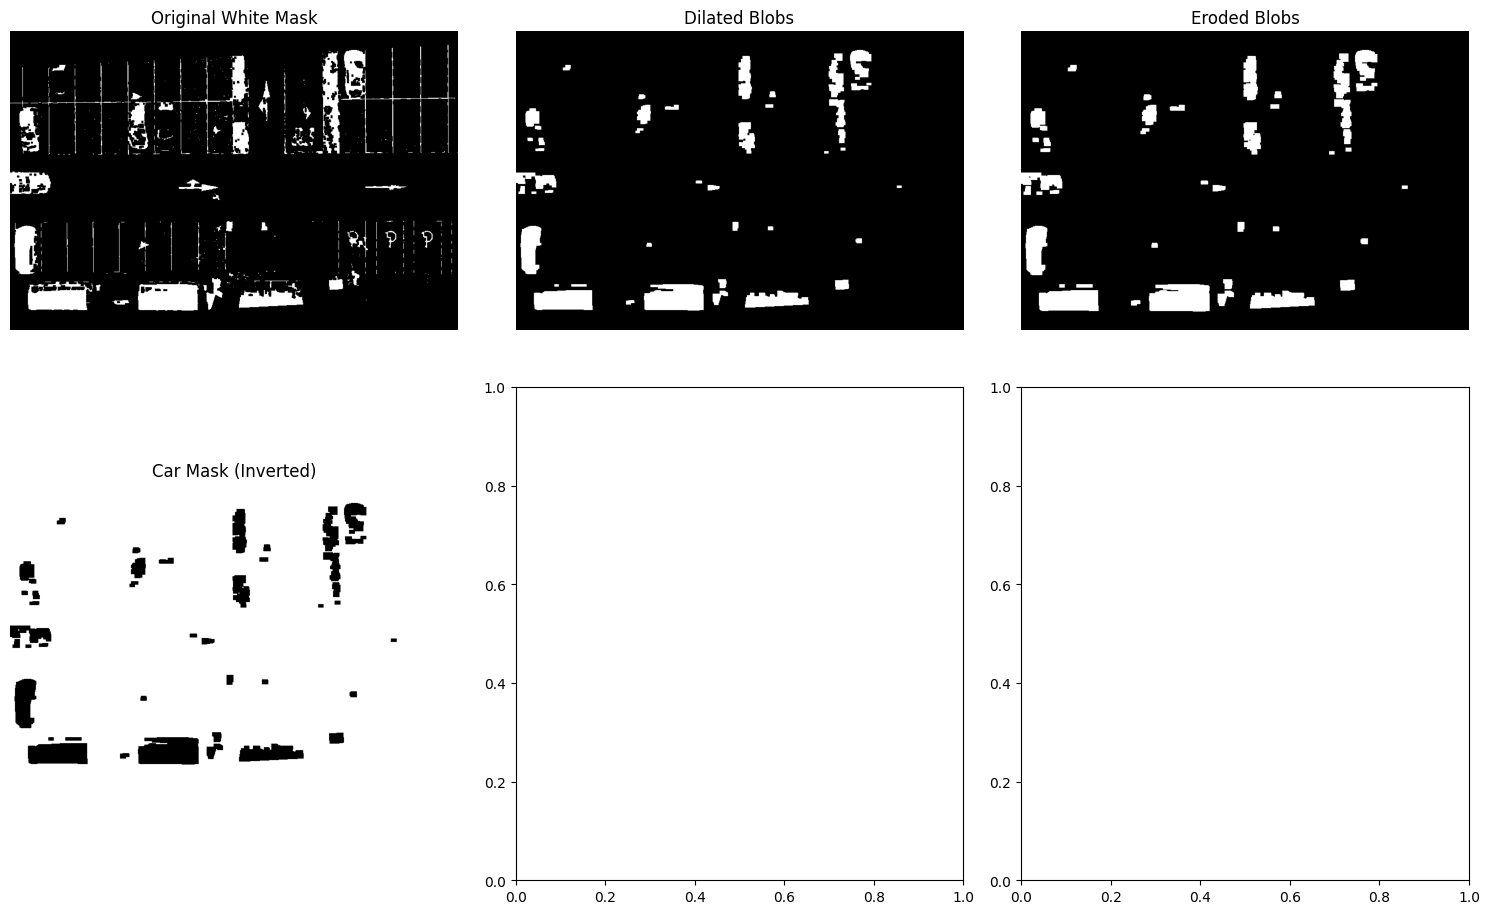

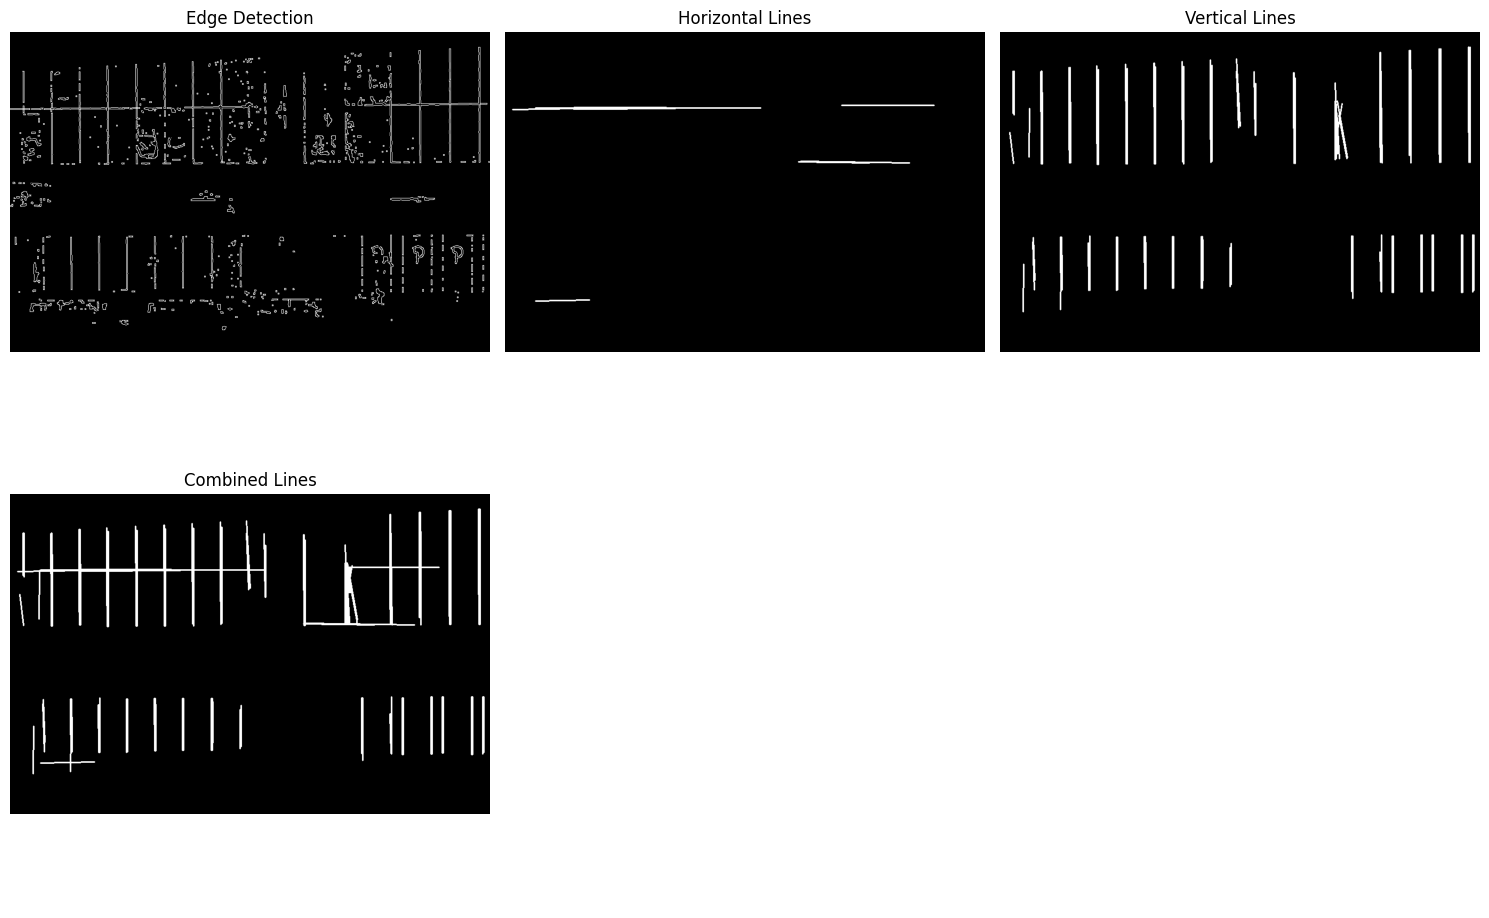

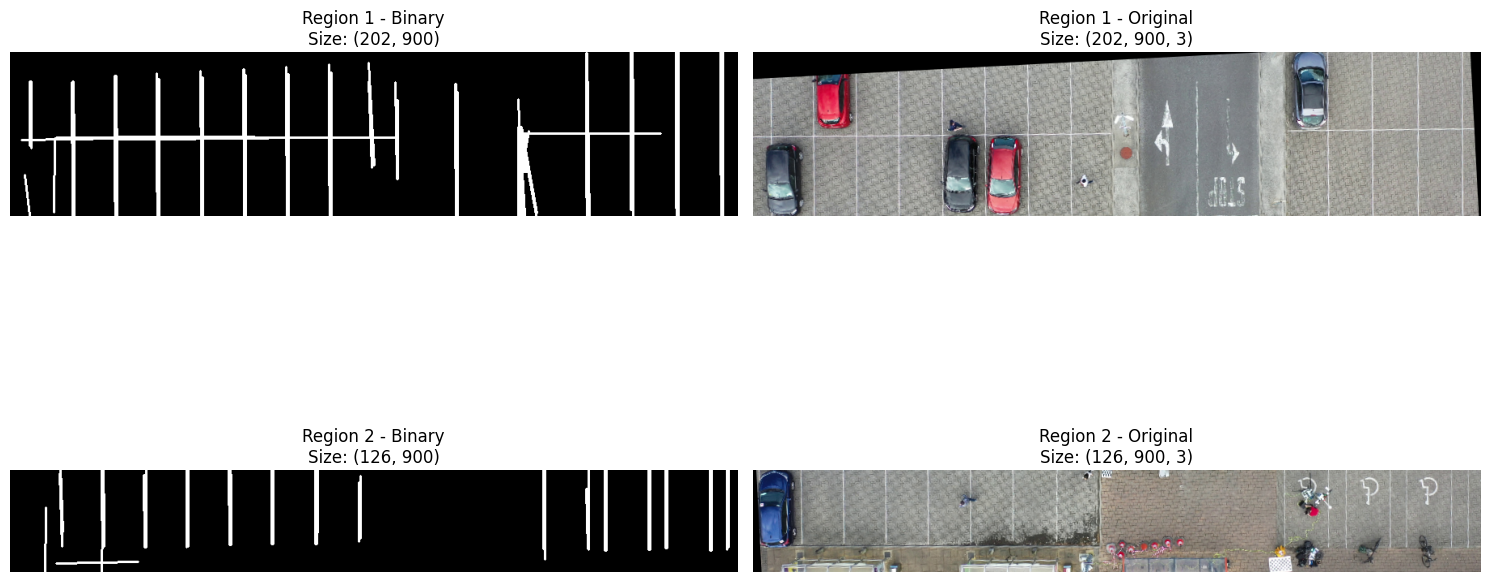

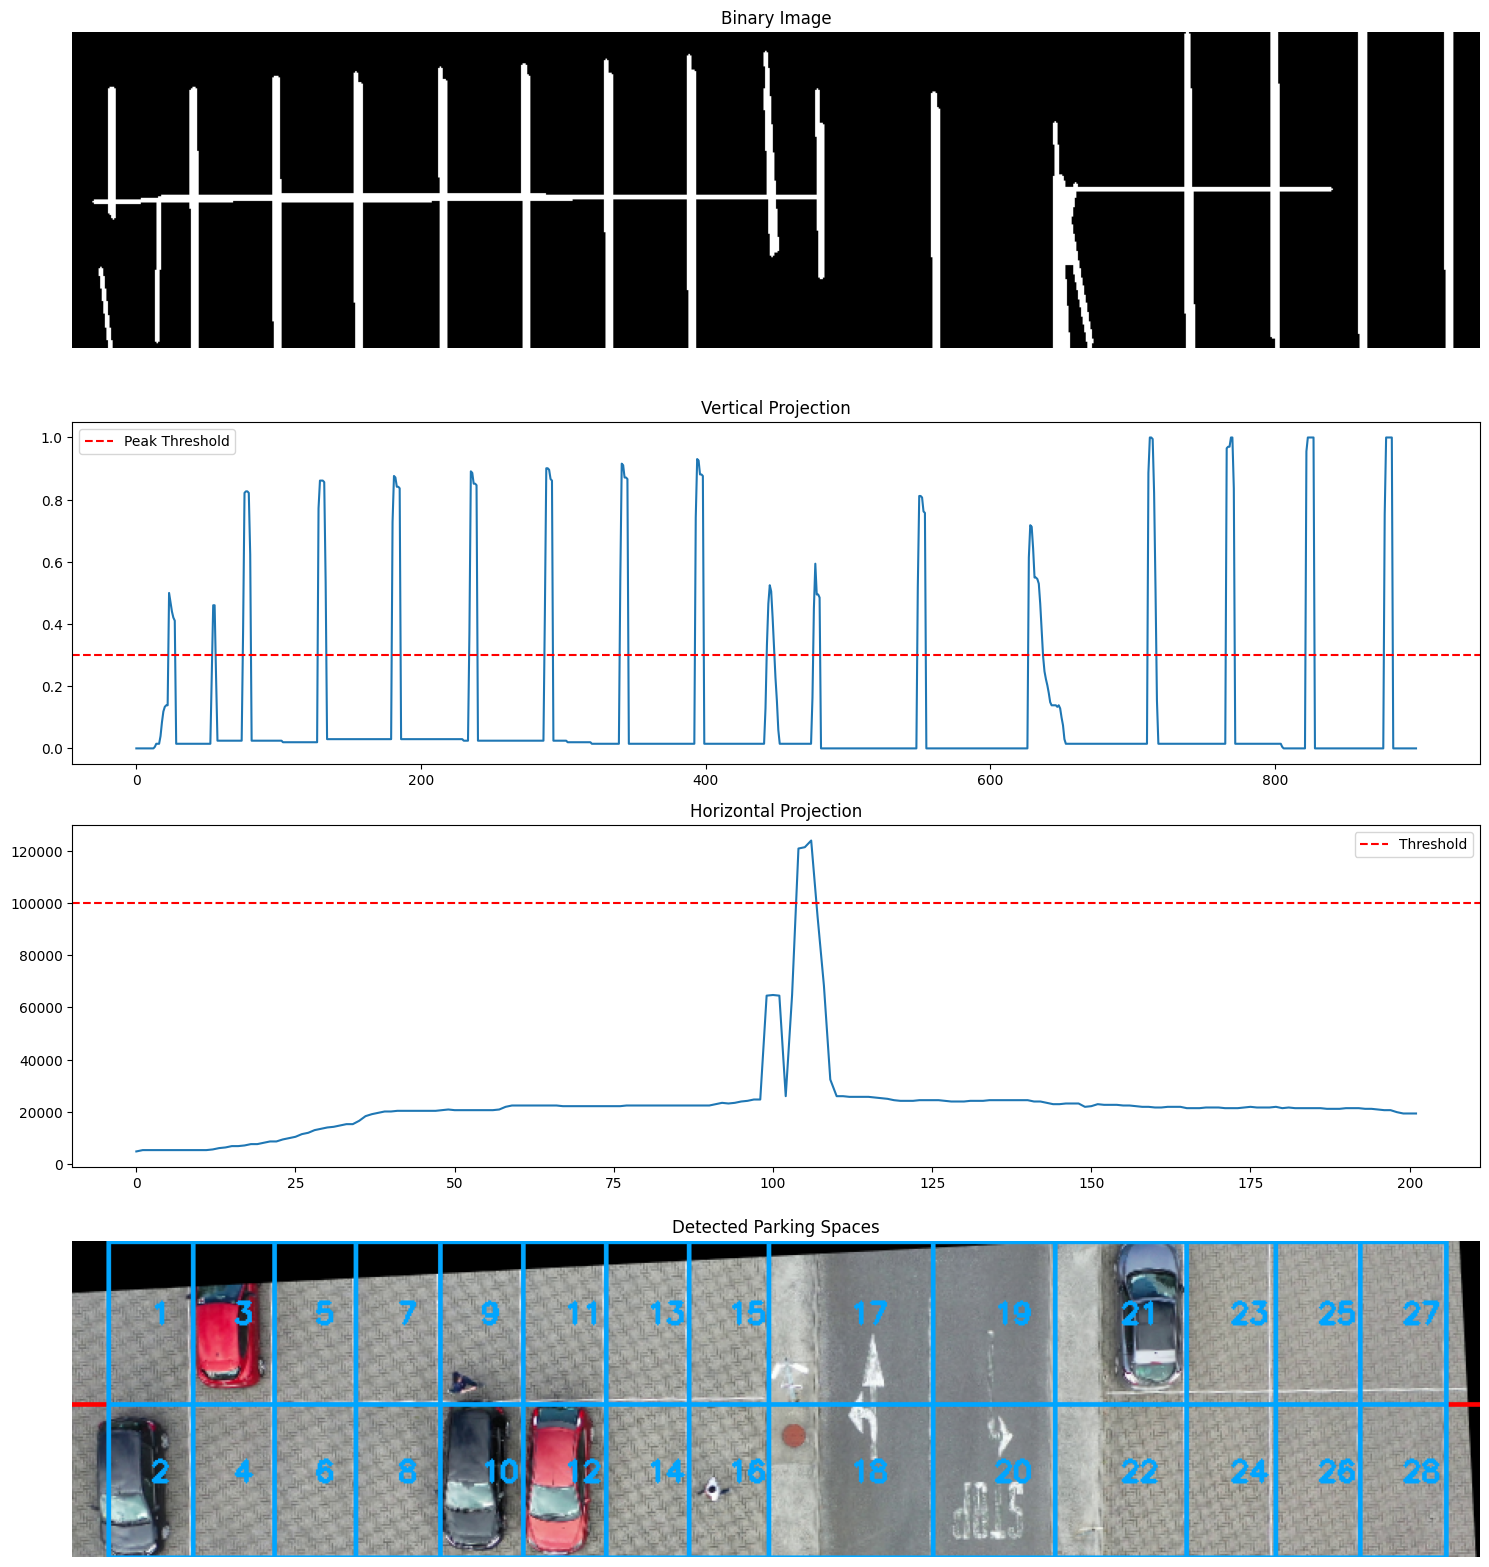


Analyzing Space 1:
Variance: 4324.40
Mean Intensity: 99.75
Edge density: 0.211

Analyzing Space 2:
Variance: 2490.44
Mean Intensity: 104.64
Edge density: 0.249

Analyzing Space 3:
Variance: 3180.68
Mean Intensity: 72.04
Edge density: 0.185

Analyzing Space 4:
Variance: 268.37
Mean Intensity: 151.00
Edge density: 0.309

Analyzing Space 5:
Variance: 4608.03
Mean Intensity: 117.17
Edge density: 0.259

Analyzing Space 6:
Variance: 282.49
Mean Intensity: 156.32
Edge density: 0.317

Analyzing Space 7:
Variance: 4391.25
Mean Intensity: 123.81
Edge density: 0.267

Analyzing Space 8:
Variance: 317.06
Mean Intensity: 153.00
Edge density: 0.346

Analyzing Space 9:
Variance: 3948.79
Mean Intensity: 118.66
Edge density: 0.276

Analyzing Space 10:
Variance: 2480.64
Mean Intensity: 94.50
Edge density: 0.255

Analyzing Space 11:
Variance: 3553.94
Mean Intensity: 129.40
Edge density: 0.309

Analyzing Space 12:
Variance: 2040.06
Mean Intensity: 120.14
Edge density: 0.245

Analyzing Space 13:
Variance: 

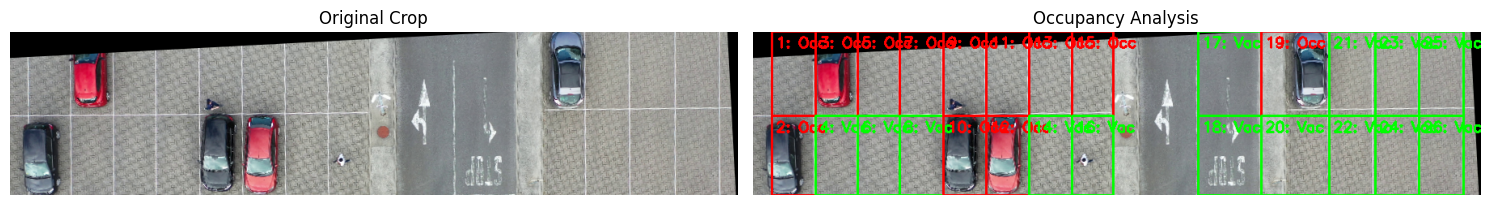

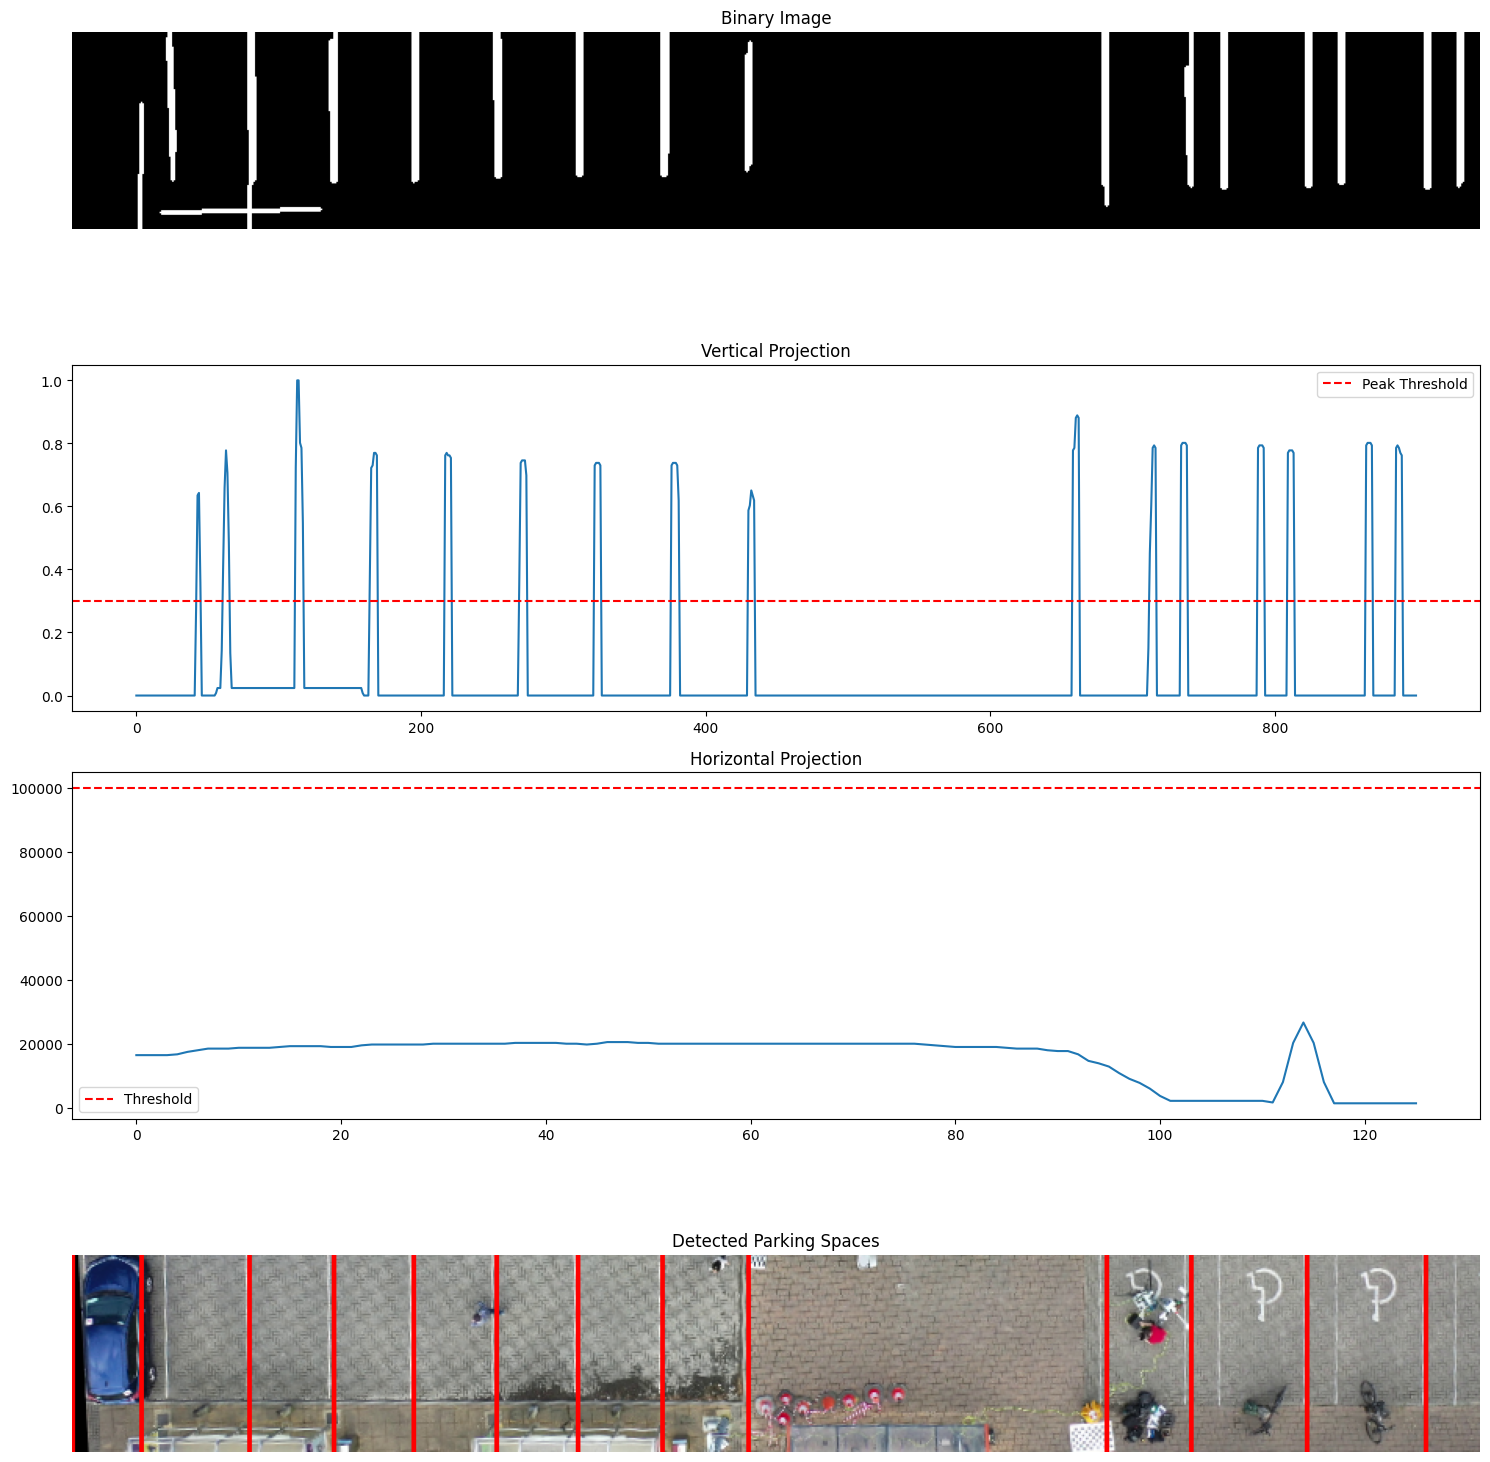


Analyzing Space 1:
Variance: 2222.37
Mean Intensity: 68.50
Edge density: 0.183

Analyzing Space 2:
Variance: 1335.04
Mean Intensity: 126.52
Edge density: 0.200

Analyzing Space 3:
Variance: 544.99
Mean Intensity: 140.14
Edge density: 0.229

Analyzing Space 4:
Variance: 428.17
Mean Intensity: 144.73
Edge density: 0.206

Analyzing Space 5:
Variance: 459.55
Mean Intensity: 143.87
Edge density: 0.268

Analyzing Space 6:
Variance: 1214.01
Mean Intensity: 141.51
Edge density: 0.318

Analyzing Space 7:
Variance: 1262.56
Mean Intensity: 143.18
Edge density: 0.306

Analyzing Space 8:
Variance: 1150.52
Mean Intensity: 141.45
Edge density: 0.339

Analyzing Space 9:
Variance: 451.50
Mean Intensity: 141.29
Edge density: 0.319

Analyzing Space 10:
Variance: 1613.07
Mean Intensity: 133.28
Edge density: 0.226

Analyzing Space 11:
Variance: 606.00
Mean Intensity: 142.92
Edge density: 0.126

Analyzing Space 12:
Variance: 546.02
Mean Intensity: 140.38
Edge density: 0.116


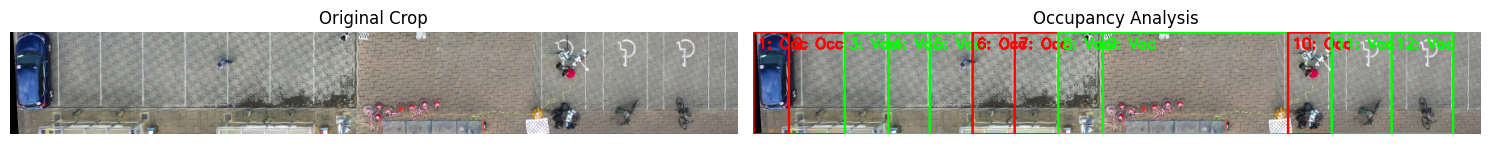

In [82]:
# Main processing loop
image_dir = 'c:/Users/Patrick/Documents/EmbeddedImageProcessing/Mini-Project/Mini_project_images/hard/*'
image_files = [file for file in glob(image_dir, recursive=True) if file.endswith(('.jpg', '.png'))]
all_results = []    

for i, file in enumerate(image_files):
    original_img = cv2.imread(file)
    if(i==0 or i==2):
        standardized = standardize_image(original_img, 600, 900)
    else:
        standardized = standardize_image(original_img, 3000, 4500) ##Changed the resolution of image two to try retain as much information as I could
    if i==0:
        standardized = rotate_image(standardized, 17) 
    if i==2:
        standardized = rotate_image(standardized, 3) ##Slight rotation applied to this image to improve performance
    parking_spaces = detect_white_lines(standardized)
    parking_lines = detect_parking_lines(parking_spaces)
    
    binary_crops, original_crops, crop_coordinates = crop_parking_regions(parking_lines, standardized)

    for binary_crop, original_crop in zip(binary_crops, original_crops):
        v_peaks, h_peaks, _  = detect_parking_spaces(binary_crop, original_crop)
        spots = extract_parking_spots(original_crop, v_peaks, h_peaks)
        cv2.waitKey(1000)
        occupancy_results, annotated_img = analyze_parking_spot_occupancy(original_crop, spots)
        all_results.extend(occupancy_results)